<img src="https://static.spin.com/files/2016/10/Amazon-Music-Logo-1476279710-640x400.png" alt="Jupyter_logo" class="img-rounded img-responsive" height="80" width="80" align="left">
<span><br><br><br></span>

<h1 align='center' style='margin-bottom: 0px'>CD电商平台消费行为分析</h1>

***
<code><b>项目背景</b></code> ：

- 本项目数据集是来源于原AmazonMusic18个月不同用户的消费流水（按日计算）
- 数据集包括用户id、日期、数量、价格。共69659条数据

<code><b>数据概览</b></code>：   

| 🛒运营数据 |  .   |  .    |  🛒用户数据  |   |
| :------ |: ------ :| :------: |:------: |:------: |
| 消费人数 | 第3月达到最高值为17000后迅速下降平缓至2000左右 | ▍|  用户质量  | 消费金额占前30%用户（7000）贡献了80%的消费金额  |
| 订单数 | 平均购买7件，平均消费$$106。购买量和数量基本聚集在低量处 | ▍ | 生命周期   |  用户的平均生命周期为135天，50%用户只消费过一次  |
| 客单价 | 36-45 | ▍ |用户留存率 |  首月留存率约47%，3月后留存率降低，趋于稳定约25%  |
| 复购率 | 第3月达到最高，维持在20~25%。复购人数维持在1000左右| ▍ |  购买周期   | 10日占最多量，基本处于1月以内    |

<code><b>结论汇总</b></code>：
- 大部分用户只消费一次便进入休眠阶段，50%的占比还是很高的，可以针对月初营销结果进行改进，挽留此类用户。
- 消费贡献占比最大的处于20-30%小部分人群，看出这部分人相当具有购买力，商品种类和价格更应该层次化更好服务此类人群。
- 大部分用户的消费间隔比较短，可以消费后立即赠送优惠券进行到期推送，留住更多稳定用户。
- 根据RFM分类结果调整施行不同的营销策略，制定不同的营销活动。

***

<span style="color:#2E85C6"><b>具体分析过程如下</b></span>


## 数据集导入
> 该数据集没有缺失值

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from datetime import datetime
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import sys
sys.path.append(r'C:\\Users\\kakason\\Documents\\Jupyter\\rfm') 
import visuals as vs
from sklearn.decomposition import PCA
import matplotlib.cm as cm
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置  
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data = pd.read_csv('G:/project/consume_behavior/CDNOW_master.txt',sep = '\s+',header=None)

In [3]:
data.columns=['user_id', 'order_dt', 'order_products','order_amount']

In [4]:
data['order_dt'] = pd.to_datetime(data['order_dt'].astype(str),format="%Y-%m-%d",errors = 'coerce')
data['month'] = data.order_dt.values.astype('datetime64[M]')

In [5]:
data.isnull().sum()

user_id           0
order_dt          0
order_products    0
order_amount      0
month             0
dtype: int64

In [6]:
user_group = data.groupby('user_id',as_index=False).sum()

In [7]:
date_group = data.groupby('month',as_index=False).sum().drop('user_id',axis = 1)

## 数据探索

### 整体消费情况
> - 消费人数自3月份上升至最高点后迅速走低，5月份趋于平缓，有可能是营销活动使得消费人数短时间骤增  
> - 客单价保持在36-42的价格之间，约为2件商品的价格（数据集看出单件CD价格基本一致）  
> - 消费金额和购买量与消费人数变化趋势一致，产品数量和金额来看相当大的集中于20张/$200以内  
> - 一半左右的顾客只购买了一次，可能是前期营销结果但后期流失掉的客户？

In [8]:
df = data[['user_id','order_dt']].drop_duplicates()   #每日顾客数量（去重）
per_customer= df.join(data,lsuffix='_l', rsuffix='_r')[['month','order_amount','user_id_l']].groupby('month').agg({'order_amount': ['sum'], 'user_id_l': ['count']})
per_customer.columns=['sum','count']
per_customer.reset_index(inplace=True)

In [9]:
per_customer['per'] = per_customer['sum']/per_customer['count']

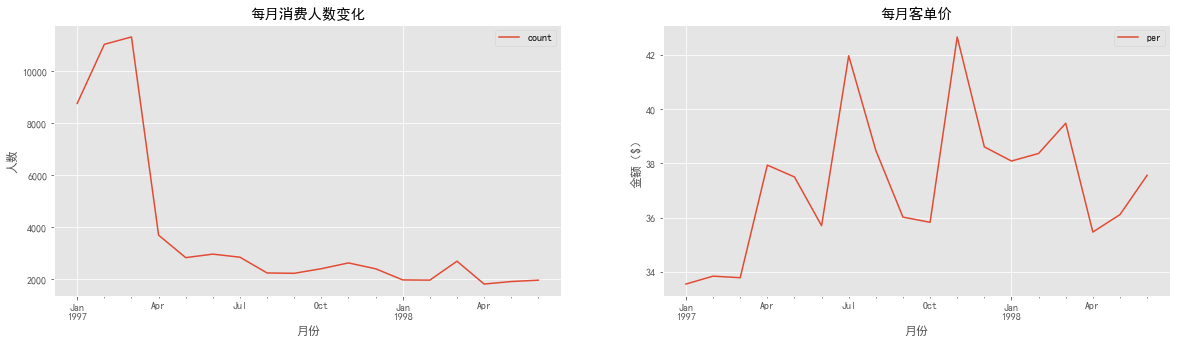

In [10]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(20,5))
per_customer.plot(x ='month',y='count',ax = axis1 )
per_customer.plot(x ='month',y='per',ax = axis2 )
axis1.set_title("每月消费人数变化");axis2.set_title("每月客单价")
axis1.set_xlabel('月份') 
axis1.set_ylabel('人数') 
axis2.set_xlabel('月份') 
axis2.set_ylabel('金额（$）') 
plt.show()

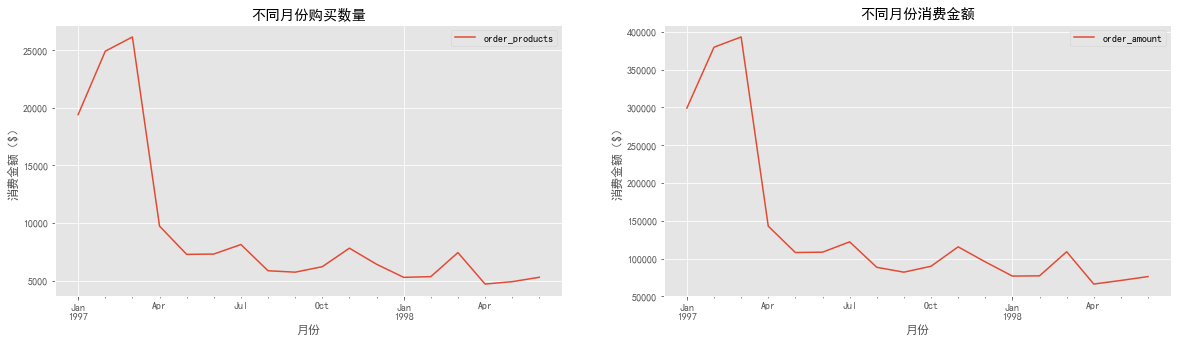

In [11]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(20,5))
date_group.plot(x ='month',y='order_products',ax = axis1 )
date_group.plot(x ='month',y='order_amount',ax = axis2 )
axis1.set_title("不同月份购买数量");axis2.set_title("不同月份消费金额")
axis1.set_xlabel('月份') 
axis1.set_ylabel('消费金额（$）') 
axis2.set_xlabel('月份') 
axis2.set_ylabel('消费金额（$）') 
plt.show()

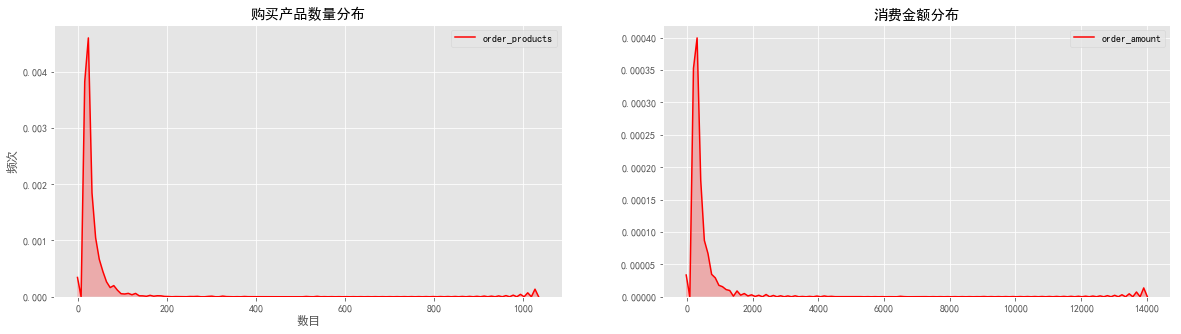

In [12]:
fig, (axis3,axis4) = plt.subplots(1,2,figsize=(20,5))
sns.kdeplot(user_group.order_products,shade=True, color="r",ax = axis3)
sns.kdeplot(user_group.order_amount,shade=True, color="r",ax = axis4)
axis3.set_title("购买产品数量分布");axis4.set_title("消费金额分布")
axis3.set_xlabel('数目');axis3.set_ylabel('频次') 
axis2.set_xlabel('金额（$）');axis2.set_ylabel('频次') 
plt.show()

In [13]:
user_group.describe()

,user_id,order_products,order_amount
count,23570.000000,23570.000000,23570.000000
mean,11785.500000,7.122656,106.080426
std,6804.217258,16.983531,240.925195
min,1.000000,1.000000,0.000000
25%,5893.250000,1.000000,19.970000
50%,11785.500000,3.000000,43.395000
75%,17677.750000,7.000000,106.475000
max,23570.000000,1033.000000,13990.930000


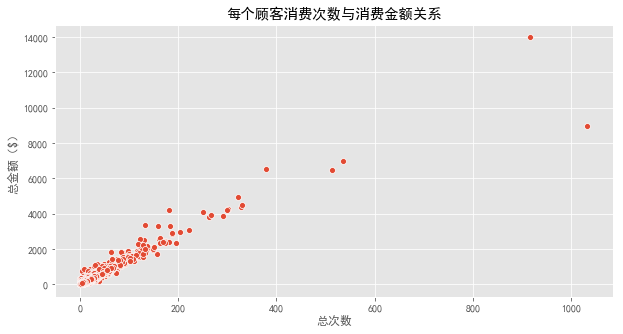

In [14]:
plt.figure(figsize=(10,5))
sns.scatterplot(x = 'order_products',y ='order_amount' ,data=data.groupby('user_id').sum())
plt.title("每个顾客消费次数与消费金额关系")
plt.xlabel('总次数');plt.ylabel('总金额（$）')
plt.show()

***
### 消费行为中的复购率
> - 4月份上升至最高点后趋于稳定为20%左右，应该是前三个月新客涌进，剩下一部分作为老客户留下了  
> - 后期稳定性可以看出老客的忠诚度表现较好，消费频次一般，这是这个网站的用户消费特征。

In [15]:
data['num']=1
data_count = data[['user_id','month','num']].pivot_table(index = 'user_id', columns = 'month',values='num',aggfunc='count')
data_count.head(10)

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
user_id,,,,,,,,,,,,,,,,,,
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
5,2.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN
6,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
8,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,2.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
9,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [16]:
pivoted_counts_data =  data_count.applymap(lambda x: 1 if x>1 else (0 if x==1 else np.NaN))

In [17]:
pivoted_counts_data.reset_index(inplace=True)

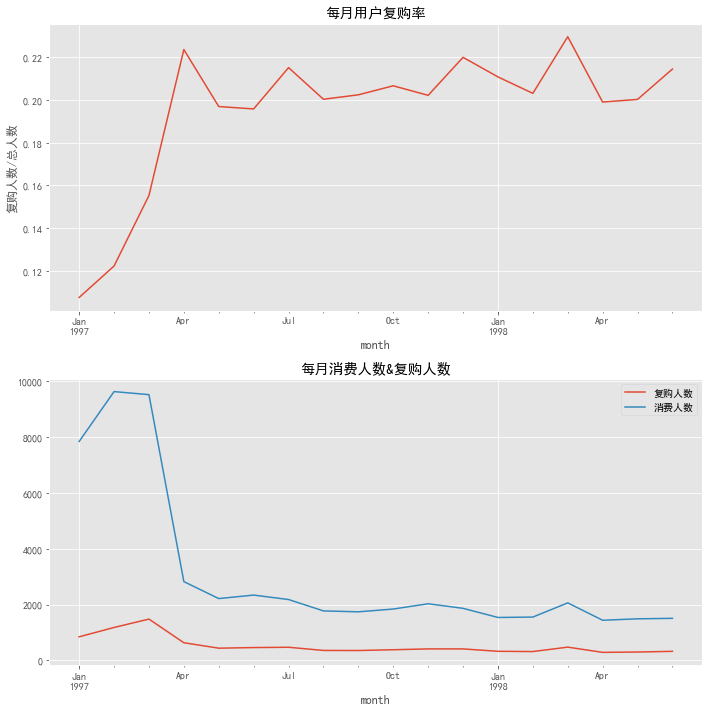

In [18]:
fig,axes = plt.subplots(2,1,figsize=(10,10))
(pivoted_counts_data.iloc[:,1:].sum()/pivoted_counts_data.iloc[:,1:].count()).plot(ax = axes[0])

axes[0].set_title("每月用户复购率")
axes[0].set_ylabel('复购人数/总人数')

pivoted_counts_data.iloc[:,1:].sum().plot(ax = axes[1])
pivoted_counts_data.iloc[:,1:].count().plot(ax = axes[1])
axes[1].set_title('每月消费人数&复购人数')
axes[1].set_ylabel=(u'人数')
axes[1].legend(['复购人数','消费人数'])
fig.tight_layout()
plt.show()

### 用户分层
>用户包含各种类型，反应了不同群体的特征和想法，我们先简单划分为以下维度：
 - 新用户（new）：第一次消费即新用户。
 - 不活跃用户（unactive）：超过连续2个月没有消费。
 - 回流用户（return）：有一段时间没消费，之后突然回来再次消费。
 - 活跃用户（active）：连续月份消费过的客户，这里默认2个月。 
 
> 由下图可知，不活跃用户占比一直很高，活跃用户比较稳定  
> 用户回流占比在5%～8%之间波动，趋势向下,有流失可能

In [19]:
purchase_time = data[['user_id','month']].groupby('user_id').apply(lambda x: x['month']-x['month'].shift()).dt.days
purchase_time.describe()

count    46089.000000
mean        68.613140
std         91.718485
min          0.000000
25%          0.000000
50%         31.000000
75%         92.000000
max        516.000000
Name: month, dtype: float64

In [20]:
data_count = data_count.fillna(0)
data_count.head()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
user_id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [21]:
def active_status(data):
    status = []
    for i in range(18):
        
        if data[i] == 0:
            if len(status) !=0:       #非第一个判定的数
                if status[i-1] == 'un':
                    status.append('un')
                else:
                    status.append('unactive')
            else:
                status.append('un')
                
        else:
            if len(status)==0:        #第一个判定的数
                status.append('new')
            else: 
                if status[i-1] =='un':
                    status.append('new')
                elif status[i-1]=='unactive':
                    status.append('return')
                else:
                    status.append('active')
    return status
                

In [22]:
pivoted_purchase_status = data_count.apply(lambda x : pd.Series(active_status(x)),axis=1)
pivoted_purchase_status.columns = data_count.columns
pivoted_purchase_status.head()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
user_id,,,,,,,,,,,,,,,,,,
1,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
2,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
3,new,unactive,return,active,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,return,unactive
4,new,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,unactive
5,new,active,unactive,return,active,active,active,unactive,return,unactive,unactive,return,active,unactive,unactive,unactive,unactive,unactive


In [23]:
pivoted_purchase_status = pivoted_purchase_status.apply(lambda x: pd.value_counts(x)).drop('un',axis=0).fillna(0)

In [24]:
pivoted_purchase_status

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
active,0.0,1157.0,1681.0,1773.0,852.0,747.0,746.0,604.0,528.0,532.0,624.0,632.0,512.0,472.0,571.0,518.0,459.0,446.0
new,7846.0,8476.0,7248.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
return,0.0,0.0,595.0,1049.0,1362.0,1592.0,1434.0,1168.0,1211.0,1307.0,1404.0,1232.0,1025.0,1079.0,1489.0,919.0,1029.0,1060.0
unactive,0.0,6689.0,14046.0,20748.0,21356.0,21231.0,21390.0,21798.0,21831.0,21731.0,21542.0,21706.0,22033.0,22019.0,21510.0,22133.0,22082.0,22064.0


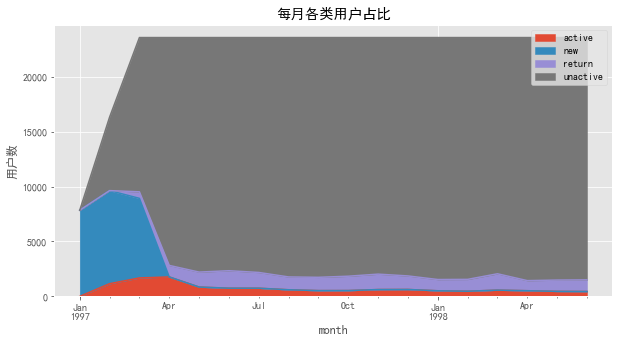

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
pivoted_purchase_status.T.plot(kind='area',ax = ax)
plt.legend(loc='upper right')
plt.title("每月各类用户占比")
ax.set_ylabel('用户数') 
plt.show()

In [26]:
#ax.stackplot(pivoted_purchase_status.columns,pivoted_purchase_status.values,labels=[ 'new','active', 'return', 'unactive'])

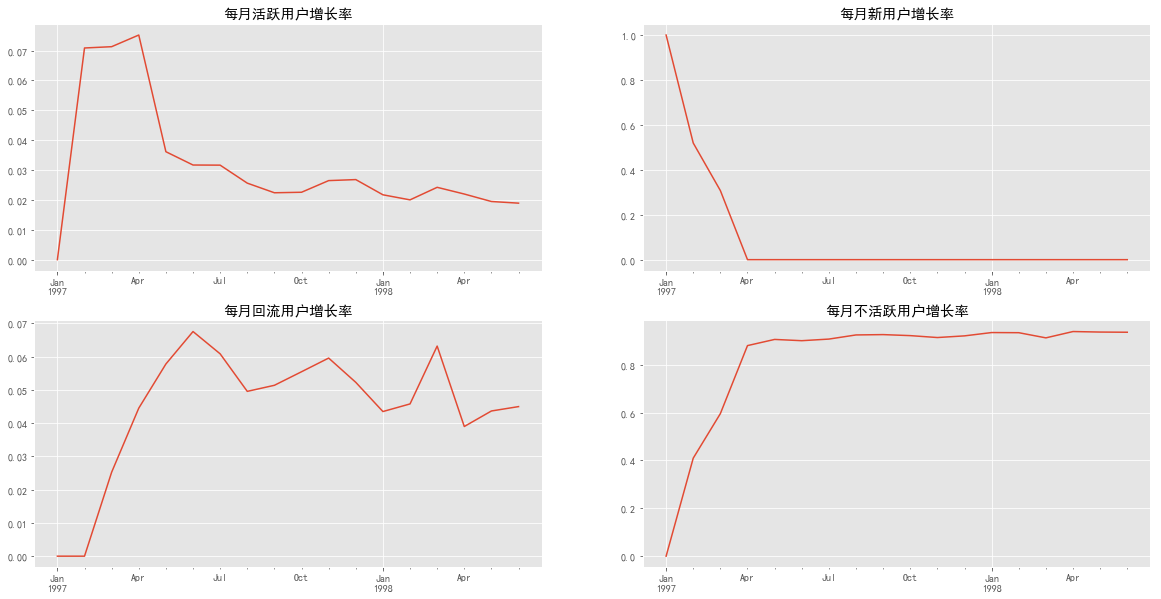

In [27]:
maping = {'active':'活跃用户','new':'新用户','return':'回流用户','unactive':'不活跃用户'}
fig,axes = plt.subplots(2,2,figsize=(20,10))
ax = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]
for i,j in enumerate(pivoted_purchase_status.index):
    (pivoted_purchase_status/pivoted_purchase_status.sum()).loc[j,:].plot(ax = ax[i])
    ax[i].set_title("每月{}增长率".format(maping[j]))
    ax[i].set_xlabel("")

### 用户质量
> 由下图可知，消费金额占前30%用户（7000）贡献了80%的消费金额

In [28]:
data_amount = data[['user_id','order_amount']].groupby("user_id").sum().sort_values(by='order_amount',ascending = False)
data_amount['sum'] = data_amount.cumsum()   #累计和
x = np.arange(0,data_amount['order_amount'].count())
y = np.array(data_amount['sum']/data_amount['order_amount'].sum())

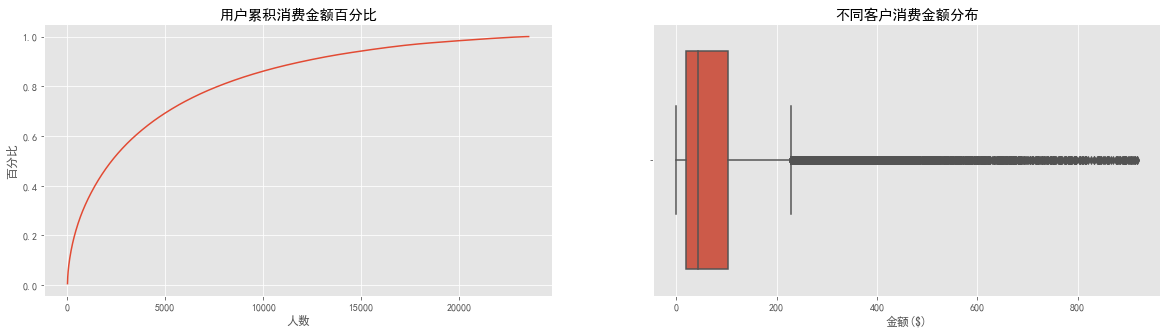

In [29]:
fig,axes = plt.subplots(1,2,figsize=(20,5))
axes[0].plot(x,y)
sns.boxplot(data_amount[data_amount['order_amount'] < np.percentile(data_amount['order_amount'],99)]['order_amount'],ax = axes[1]);
axes[0].set_title("用户累积消费金额百分比");axes[0].set_xlabel("人数");axes[0].set_ylabel("百分比");
axes[1].set_title("不同客户消费金额分布");axes[1].set_xlabel("金额($)")
plt.show()

### 用户生命周期
这里我们定义第一次消费至最后一次消费为整个用户生命。我们需要找出每个用户的第一次消费和最后次消费。
> 用户的平均生命周期为135天，50%用户只消费过一次  
> 在30内和450天左右达到顶峰，看出30日是营销结果，450日是忠实老用户，首次消费30日内应尽量引导避免流失

In [30]:
order_date_min = pd.DataFrame(data.groupby('user_id').order_dt.min())
order_date_max = pd.DataFrame(data.groupby('user_id').order_dt.max())

In [31]:
data_date = order_date_min.join(order_date_max,lsuffix='_l', rsuffix='_r')

In [32]:
data_date['days'] = (data_date['order_dt_r']-data_date['order_dt_l']).dt.days

In [33]:
data_date['days'].describe()

count    23570.000000
mean       134.871956
std        180.574109
min          0.000000
25%          0.000000
50%          0.000000
75%        294.000000
max        544.000000
Name: days, dtype: float64

In [34]:
data_date.dtypes

order_dt_l    datetime64[ns]
order_dt_r    datetime64[ns]
days                   int64
dtype: object

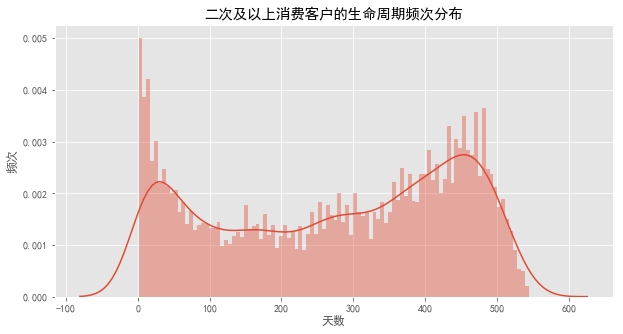

In [35]:
plt.figure(figsize=(10,5))
sns.distplot(data_date[data_date['days']>0]['days'],bins=100)
plt.title("二次及以上消费客户的生命周期频次分布")
plt.xlabel("天数");plt.ylabel("频次")
plt.show()

### 用户留存率&购买周期
> 首月留存率约47%，3月后留存率降低，趋于稳定约25%  
> 大部分购买周期间隔较短

In [36]:
data_min=pd.DataFrame(data.groupby("user_id")['order_dt'].min()).reset_index()

In [37]:
data_retention = data.merge(data_min,on='user_id',how = 'left')[['user_id','order_dt_x','order_dt_y','num']]

In [38]:
data_retention['retention'] = (data_retention['order_dt_x']-data_retention['order_dt_y']).dt.days

In [39]:
bin = [0,30,60,90,120,150,180]
data_retention['retention'] = pd.cut(data_retention.retention,bins = bin)

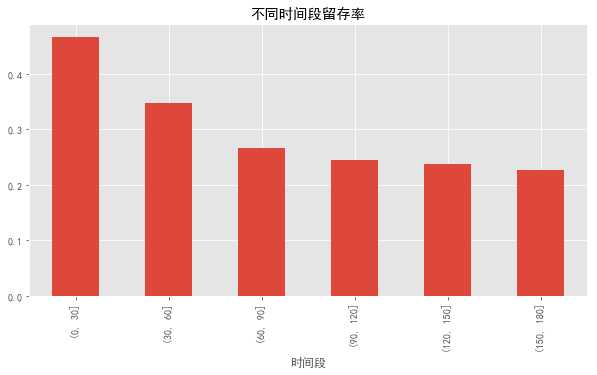

In [40]:
plt.figure(figsize=(10,5))
data_retention_trans = data_retention.groupby(['user_id','retention'])['num'].sum().unstack().fillna(0).applymap(lambda x: 1 if x >0 else 0)
ax = (data_retention_trans.sum()/data_retention_trans.count()).plot.bar(color='#DE483B')
ax.set_title("不同时间段留存率")
ax.set_xlabel("时间段")
plt.show()

In [41]:
#ax = sns.countplot(data_retention.retention)

In [42]:
purchase_cycle = pd.DataFrame(data.groupby("user_id").apply(lambda x:x.order_dt.shift(-1)-x.order_dt))

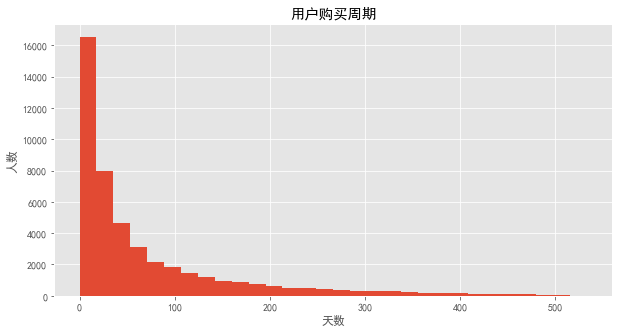

In [43]:
purchase_cycle['order_dt'].dt.days.hist(bins = 30, figsize=(10, 5))
plt.xlabel("天数");plt.ylabel("人数");plt.title("用户购买周期")
plt.show()

## RMF模型用户细分

> 重要保持客户：消费金额、购买次数均属于最高，消费周期最短的一类人群  
> 重要发展客户：潜在的高价值客户，虽然当前价值不高但有发展潜力  
> 重要挽留客户：客户价值变化的不确定性很高  
> 一般客户

In [44]:
data_min= pd.DataFrame(data.groupby('user_id')['order_dt'].min()).reset_index()

In [45]:
#建立窗口时间
data['date'] = datetime(1999,1,1)

In [46]:
data_resort = data.merge(data_min,on='user_id',how='left')
data_resort['gap'] = (data_resort['date']-data_resort['order_dt_y']).dt.days

In [47]:
data_resort = data_resort.groupby(['user_id']).agg({'order_amount': ['sum'], 'gap': ['mean'],'user_id': ['count']}).reset_index()

In [48]:
data_resort.columns=['user_id','M','R','F']

In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(data_resort.iloc[:,1:])
x_std = scaler.transform(data_resort.iloc[:,1:])

F:\anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
F:\anaconda\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [50]:
x_std = pd.DataFrame(x_std);x_std.columns=['M','R','F']

In [51]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [52]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(x_std)
    wcss.append(kmeans.inertia_)

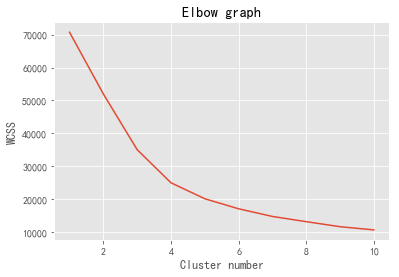

In [53]:
plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

In [54]:
#所以k值取4最合理
kmodel = KMeans(n_clusters = 4,n_jobs = 4).fit(x_std)
clusters = kmodel.fit_predict(x_std)
kmeans_center  = kmodel.cluster_centers_

In [55]:
label = pd.DataFrame(clusters);label.columns=['class']
data_resort['class'] = label['class']

In [56]:
cm = sns.light_palette("red", as_cmap=True)
classtable = data_resort.groupby('class')['M','R','F'].mean().rename(index={1:'重要挽留客户',0:'重要发展客户',2:'重要保持客户',3:'一般客户'},columns={'M':'平均消费金额','R':'平均消费周期','F':'平均购买次数'})

In [57]:
classtable.sort_values(by='平均消费金额',ascending = False).style.background_gradient(cmap=cm)

,平均消费金额,平均消费周期,平均购买次数
class,,,
重要保持客户,4541.29,692.826,82.5217
重要挽留客户,645.925,689.153,14.319
重要发展客户,71.2689,707.487,2.21614
一般客户,69.7462,667.247,2.22477


In [58]:
pca = PCA(n_components=2)
re_data = pca.fit_transform(x_std[['M','R','F']])

In [59]:
re_data =pd.DataFrame(re_data, columns = ['Dimension 1', 'Dimension 2'])
kmodel = KMeans(n_clusters = 4,n_jobs = 4).fit(re_data)
clusters_ = kmodel.fit_predict(re_data)
kmeanscenter_  = kmodel.cluster_centers_

In [62]:
def cluster(reduced_data, preds, centers):
	predictions = pd.DataFrame(preds, columns = ['Cluster'])
	plot_data = pd.concat([predictions, reduced_data], axis = 1)
	s = {1:'重要挽留客户',0:'重要发展客户',2:'重要保持客户',3:'一般客户'}
	fig, ax = plt.subplots(figsize = (14,8))
	color = ['r','#87BD32','#FCD72B','#535A6A']
	for i, cluster in plot_data.groupby('Cluster'):   
	    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2',c=color[i],label = s[i], s=30);

	# Plot centers with indicators
	for i, c in enumerate(centers):
	    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
	               alpha = 1, linewidth = 2, marker = 'o', s=200);
	    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

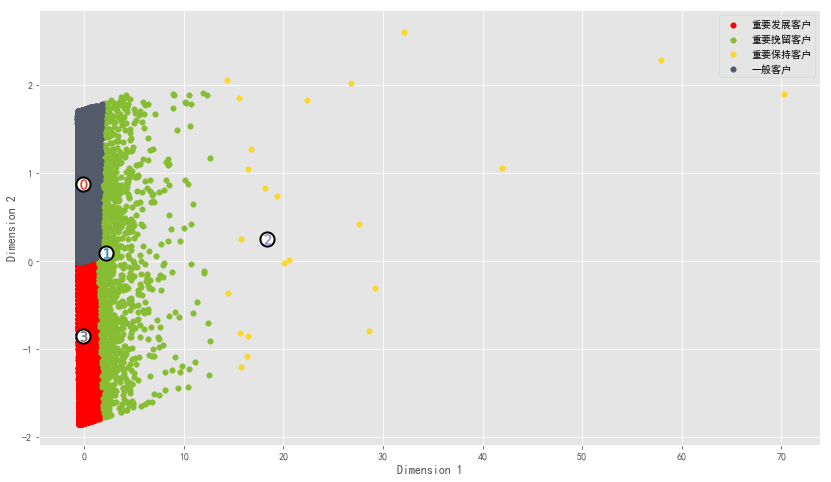

In [63]:
cluster(re_data,clusters,kmeans_center)

***